Dataset Shape: (4024, 15)
   Age                                               Race  \
0   43  Other (American Indian/AK Native, Asian/Pacifi...   
1   47  Other (American Indian/AK Native, Asian/Pacifi...   
2   67                                              White   

                   Marital Status T Stage N Stage 6th Stage  \
0  Married (including common law)      T2      N3      IIIC   
1  Married (including common law)      T2      N2      IIIA   
2  Married (including common law)      T2      N1       IIB   

                                 Grade   A Stage  Tumor Size Estrogen Status  \
0  Moderately differentiated; Grade II  Regional          40        Positive   
1  Moderately differentiated; Grade II  Regional          45        Positive   
2     Poorly differentiated; Grade III  Regional          25        Positive   

  Progesterone Status  Regional Node Examined  Reginol Node Positive  \
0            Positive                      19                     11   
1          

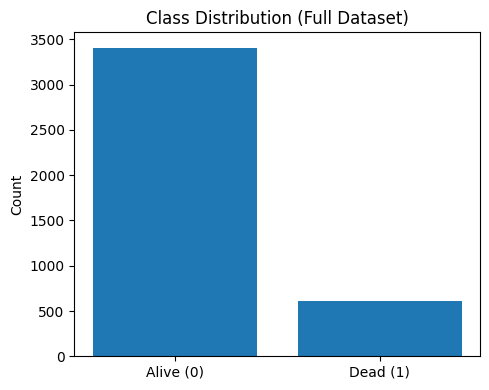

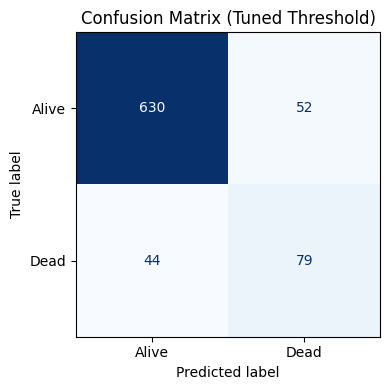

<Figure size 600x500 with 0 Axes>

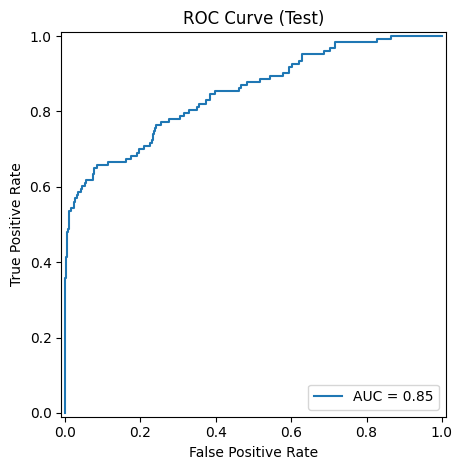

<Figure size 600x500 with 0 Axes>

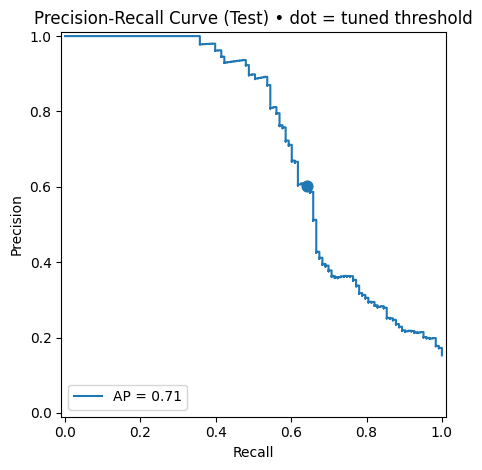

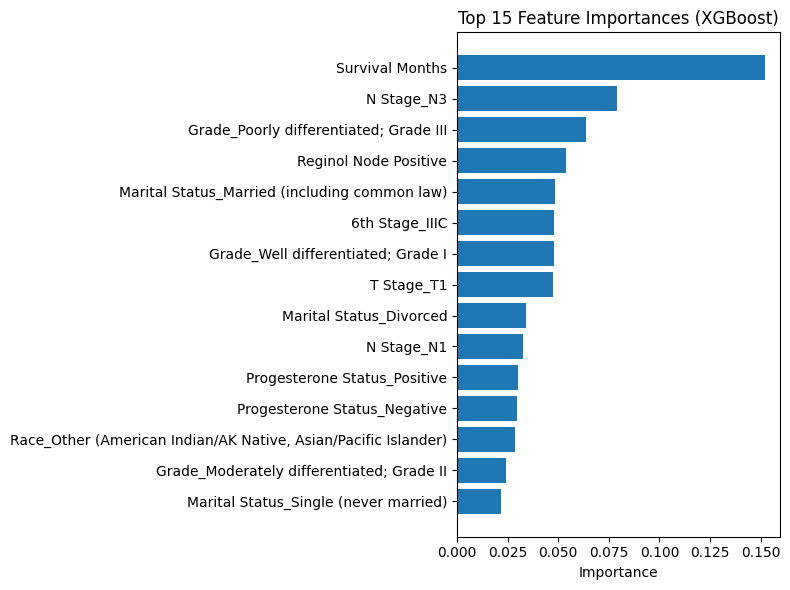

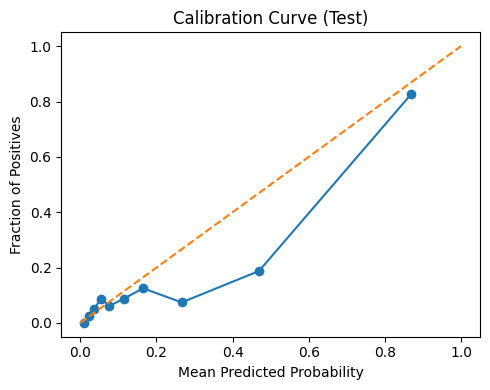

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline  
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve,
    balanced_accuracy_score,
    accuracy_score,
    f1_score,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)
from sklearn.calibration import calibration_curve


from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from scipy.stats import randint, uniform


#  Load CSV robustly

fname_candidates = ["SEER_Breast_Cancer_Dataset.csv"]
df = None
for fn in fname_candidates:
    try:
        df = pd.read_csv(fn)
        break
    except FileNotFoundError:
        pass

if df is None:
    raise FileNotFoundError(
        "Could not find 'SEER_Breast_Cancer_Dataset.csv' or 'SEER_Breast_Cancer_Dataset .csv' in the working directory."
    )

# Clean column names, drop unnamed junk
df.columns = df.columns.str.strip()
df = df.loc[:, ~df.columns.str.contains("^Unnamed", case=False, regex=True)]

print(f"Dataset Shape: {df.shape}")
print(df.head(3))


#  Target setup

# Expecting 'Status' with values 'Alive'/'Dead'
if "Status" not in df.columns:
    raise ValueError(f"'Status' column not found. Available columns: {list(df.columns)}")

df["Status"] = df["Status"].map({"Alive": 0, "Dead": 1})
if df["Status"].isna().any():
    raise ValueError("Status column could not be mapped to {Alive, Dead}. Please check values.")

y = df["Status"].astype(int)
X = df.drop(columns=["Status"])


#  Feature types

cat_cols = X.select_dtypes(include=["object"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()


#  Preprocessing

# Numeric: impute median -> scale
num_pipe = SkPipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

# Categorical: impute most_frequent -> one-hot dense (needed for SMOTE)
cat_pipe = SkPipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols),
    ],
    remainder="drop",
)


#  Train/Test split (stratified)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


#  Full pipeline: preprocess -> SMOTE -> XGB

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",      
    n_jobs=-1,
    random_state=42,
    tree_method="hist",
)

pipe = Pipeline(steps=[
    ("pre", preprocessor),
    ("smote", SMOTE(random_state=42, k_neighbors=5)),
    ("xgb", xgb),
])

#  Hyperparameter search space

param_dist = {
    "xgb__n_estimators": randint(300, 900),
    "xgb__max_depth": randint(3, 10),
    "xgb__learning_rate": uniform(0.01, 0.2),
    "xgb__subsample": uniform(0.6, 0.4),        
    "xgb__colsample_bytree": uniform(0.6, 0.4), 
    "xgb__reg_alpha": uniform(0.0, 1.0),
    "xgb__reg_lambda": uniform(0.5, 2.0),
    "xgb__gamma": uniform(0.0, 0.3),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_dist,
    n_iter=40,                 
    scoring="average_precision",   
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1,
)

search.fit(X_train, y_train)
print("\nBest CV PR-AUC:", f"{search.best_score_:.6f}")
print("Best Params:", search.best_params_)

best_model = search.best_estimator_

#  Choose a decision threshold on TRAIN 

y_train_proba = best_model.predict_proba(X_train)[:, 1]
prec, rec, thr = precision_recall_curve(y_train, y_train_proba)
f1s = np.where((prec + rec) > 0, 2 * (prec * rec) / (prec + rec), 0)
best_idx = np.argmax(f1s)
best_threshold = 0.5 if best_idx >= len(thr) else thr[best_idx]
print(f"\nChosen decision threshold from train (max F1): {best_threshold:.4f}")


# Final evaluation on TEST

y_test_proba = best_model.predict_proba(X_test)[:, 1]
y_test_pred_default = (y_test_proba >= 0.5).astype(int)
y_test_pred_tuned = (y_test_proba >= best_threshold).astype(int)

def summarize_results(name, y_true, y_pred, y_proba):
    print(f"\n=== {name} ===")
    print("Accuracy           :", f"{accuracy_score(y_true, y_pred):.6f}")
    print("Balanced Accuracy  :", f"{balanced_accuracy_score(y_true, y_pred):.6f}")
    print("F1 Score           :", f"{f1_score(y_true, y_pred):.6f}")
    print("ROC-AUC            :", f"{roc_auc_score(y_true, y_proba):.6f}")
    print("PR-AUC (AvgPrec)   :", f"{average_precision_score(y_true, y_proba):.6f}")
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=6))

summarize_results("Test @ default threshold 0.5", y_test, y_test_pred_default, y_test_proba)
summarize_results(f"Test @ tuned threshold {best_threshold:.4f}", y_test, y_test_pred_tuned, y_test_proba)


#  Visualizations


#  Class distribution
plt.figure(figsize=(5,4))
value_counts = y.value_counts().sort_index()
plt.bar(["Alive (0)", "Dead (1)"], value_counts.values)
plt.title("Class Distribution (Full Dataset)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

#  Confusion Matrix (tuned threshold)
cm = confusion_matrix(y_test, y_test_pred_tuned)
disp = ConfusionMatrixDisplay(cm, display_labels=["Alive", "Dead"])
fig, ax = plt.subplots(figsize=(5,4))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("Confusion Matrix (Tuned Threshold)")
plt.tight_layout()
plt.show()

#  ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure(figsize=(6,5))
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_score(y_test, y_test_proba)).plot()
plt.title("ROC Curve (Test)")
plt.tight_layout()
plt.show()

#  Precision-Recall Curve with chosen threshold point
prec_t, rec_t, thr_t = precision_recall_curve(y_test, y_test_proba)
plt.figure(figsize=(6,5))
PrecisionRecallDisplay(precision=prec_t, recall=rec_t, average_precision=average_precision_score(y_test, y_test_proba)).plot()

if len(thr_t) > 0:
    idx = np.argmin(np.abs(thr_t - best_threshold))
    plt.scatter(rec_t[idx], prec_t[idx], s=60)
plt.title("Precision-Recall Curve (Test) • dot = tuned threshold")
plt.tight_layout()
plt.show()

#  Feature importance (top 15) — use column names after preprocessing

def get_feature_names(ct: ColumnTransformer) -> list:
    names = []
    for name, trans, cols in ct.transformers_:
        if name == "remainder" and trans == "drop":
            continue
        if hasattr(trans, "named_steps"):
            # It is a pipeline
            last = list(trans.named_steps.values())[-1]
            if isinstance(last, OneHotEncoder):
                feat_names = last.get_feature_names_out(cols).tolist()
            else:
                feat_names = list(cols)
        else:
            # Not a pipeline
            if isinstance(trans, OneHotEncoder):
                feat_names = trans.get_feature_names_out(cols).tolist()
            else:
                feat_names = list(cols)
        names.extend(feat_names)
    return names

xgb_est = best_model.named_steps["xgb"]
feature_names = get_feature_names(best_model.named_steps["pre"])
importances = xgb_est.feature_importances_
order = np.argsort(importances)[::-1]

top_k = min(15, len(importances))
plt.figure(figsize=(8,6))
plt.barh(range(top_k), importances[order][:top_k][::-1])
plt.yticks(range(top_k), np.array(feature_names)[order][:top_k][::-1])
plt.xlabel("Importance")
plt.title("Top 15 Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()

#  Calibration curve 
prob_true, prob_pred = calibration_curve(y_test, y_test_proba, n_bins=10, strategy="quantile")
plt.figure(figsize=(5,4))
plt.plot(prob_pred, prob_true, marker="o")
plt.plot([0,1],[0,1],"--")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve (Test)")
plt.tight_layout()
plt.show()
